# Explore iOS health
### Explore and visualize data from the iOS health app

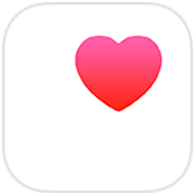

This project can be used to explore, visualize and investigate the data provided by the iOS health app. The data can be exported to a XML file by tapping on the profile icon in the right corner in the health app.

For more information on the Apple health app visit: [https://www.apple.com/ios/health/](https://www.apple.com/ios/health/)



---




# Prepare notebook

Install [Dask](https://dask.org/).


In [ ]:
!pip install dask
!pip install dask[dataframe] --upgrade

Only needed for Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%matplotlib inline
import xml.etree.ElementTree as et
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import time, datetime

Set pathes for ``Export.xml`` and ``df.csv``. **These must be adjusted!**





In [ ]:
export_xml_file_path = '/content/drive/My Drive/explore_ios_health/apple_health_export/Export.xml'
apple_health_csv_file_path = '/content/drive/My Drive/explore_ios_health/apple_health_export/df.csv'

# Collect data from XML

Get attributes from XML file.

In [ ]:
xtree = et.parse(export_xml_file_path)
xroot = xtree.getroot()

In [ ]:
def rows_columns():
  
  types = set([])
  rows = []
    
  for node in xroot[0:]: 

    types.add(node.attrib.get('type'))
    
    # Add more HK types here
    if node.attrib.get('type') == 'HKQuantityTypeIdentifierHeartRate' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierActiveEnergyBurned' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierDistanceWalkingRunning' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierAppleExerciseTime' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierAppleStandTime' or \
      node.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':    

        s_type = node.attrib.get('type')
        s_unit = node.get('unit')
        s_date = node.get('startDate')
        s_value = float(node.get('value'))
        s_source = node.get('sourceName')

        columns = ['type','source', 'unit', 'dateTime', 'value']
        
        rows.append({'type': s_type, 
                     'unit': s_unit, 
                     'dateTime': s_date,
                     'source': s_source, 
                     'value': s_value})


  print('Available data types:')
  for data_type in types:
    print(data_type) 
  return (rows, columns) 

Create Pandas data frame from rows and columns.

In [ ]:
rows, columns = rows_columns()
df = pd.DataFrame(rows, columns=columns)
df = df.dropna()

print(f'\nShape:{df.shape}')
df.head()

Remove objects to free some space.

In [ ]:
del(rows)
del(columns)
del(xtree)
del(xroot)

# *Load and store CSV (optional)*

Store data frame in CSV if needed.

In [ ]:
df.to_csv(apple_health_csv_file_path, index=False)

Load data frame from CSV if needed.

In [ ]:
df = pd.read_csv(apple_health_csv_file_path)

print(f'\nShape:{df.shape}')
df.head()

# Clean, format and manage data

Two different merge functions used for putting the final data frame together.

In [ ]:
def merge_date_formated_df(df, data_type, column_name, grouped_strategy):
    
    # Get all rows from `data_type`
    grouped_df = df[df['type'].isin([data_type])]
    grouped_df = grouped_df.drop({'type','source','unit'}, axis=1)
    grouped_df = grouped_df.rename(columns={'value': column_name})

    # Floor `date_time` to minutes
    date_time = pd.to_datetime(grouped_df['dateTime'])
    date_time = date_time.dt.tz_localize(None)
    grouped_df['dateTime'] = date_time.dt.floor('min').copy()

    # Group by `date_time` and set value to mean or sum
    if grouped_strategy == 'Mean':
        grouped_df = round(grouped_df.groupby('dateTime', as_index=False).mean(), 0)
    elif grouped_strategy == 'Sum':
        grouped_df = round(grouped_df.groupby('dateTime', as_index=False).sum(), 4)
    else:
        raise ValueError(
            "Invalid value for 'grouped_strategy'! Should be either 'mean' or 'sum'.")
    
    # Create new `date` column
    date = pd.to_datetime(grouped_df['dateTime'])
    date = date.dt.tz_localize(None)
    grouped_df['date'] = date.dt.floor('d').copy()

    # Use new `date` column to create new columns containing the average or the sum
    if grouped_strategy == 'Mean':
      new_df = pd.DataFrame(grouped_df.groupby('date', as_index=False)[column_name].mean())
    elif grouped_strategy == 'Sum':
      new_df = pd.DataFrame(grouped_df.groupby('date', as_index=False)[column_name].sum())

    new_df = new_df.rename(columns={column_name: f'{column_name}{grouped_strategy}'})
    merged = pd.merge(grouped_df, new_df, on='date', how='outer')
    merged = merged.set_index('dateTime')
    return merged

def merge(dataframes_list):
    if len(dataframes_list) < 2:
        raise ValueError(
            "'dataframes_list' should contain at least two dataframes!")

    merged = dataframes_list[0].merge(dataframes_list[1], how='outer',
                      left_index=True, right_index=True)

    if len(dataframes_list) > 2:
        for df in dataframes_list[2:]:
            merged = merged.merge(df, how='outer',
                              left_index=True, right_index=True)
    return merged

Store data frames to CSV to handle them with desk.

In [ ]:
merge_date_formated_df(
    df, 'HKQuantityTypeIdentifierHeartRate', 
    'heartRate(BPM)', 
    'Mean').to_csv("hr_temp.csv")

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierDistanceWalkingRunning', 
    'walkingRunningDistance(km)', 
    'Sum').to_csv('wd_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierActiveEnergyBurned', 
    'activeEnergyBurned(kal)', 
    'Sum').to_csv('aeb_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierAppleStandTime', 
    'standTime(min)', 
    'Sum').to_csv('st_temp.csv',index_label='dateTime')

merge_date_formated_df(
    df, 
    'HKQuantityTypeIdentifierStepCount', 
    'stepCount', 'Sum').to_csv('sc_temp.csv',index_label='dateTime')

Load data frames from using [Desk](https://dask.org/). This is needed so it can handle big data frame.

In [ ]:
hr = dd.read_csv('hr_temp.csv').set_index('dateTime')
wd = dd.read_csv('wd_temp.csv').set_index('dateTime')
aeb = dd.read_csv('aeb_temp.csv').set_index('dateTime')
st = dd.read_csv('st_temp.csv').set_index('dateTime')
sc = dd.read_csv('sc_temp.csv').set_index('dateTime')

Merge the different data frames together and handle NaNs.

In [ ]:
df_list = [df.drop(columns={'date'}) for df in [hr, wd, aeb, st, sc]]

merged = merge(df_list)

merged['standTime(min)'] = merged['standTime(min)'].fillna(0.0)
merged['standTime(min)Sum'] = merged['standTime(min)Sum'].fillna(0.0)
merged['stepCount'] = merged['stepCount'].fillna(0)
merged['stepCountSum'] = merged['stepCountSum'].fillna(0)
merged['activeEnergyBurned(kal)'] = merged['activeEnergyBurned(kal)'].fillna(0.0)
merged['activeEnergyBurned(kal)Sum'] = merged['activeEnergyBurned(kal)Sum'].fillna(0.0)
merged['walkingRunningDistance(km)'] = merged['walkingRunningDistance(km)'].fillna(0.0)
merged = merged.dropna()
print(type(merged))

Remove objects to free some space.

In [ ]:
del(hr)
del(wd)
del(aeb)
del(st)
del(sc)

For split dateTime, rouning numbers and change order.

In [ ]:
def formated_df(df):
  df = df.round({
    'heartRate(BPM)':1, 
    'heartRate(BPM)Mean':1, 
    'walkingRunningDistance(km)':4,
    'walkingRunningDistance(km)Sum':4,
    'activeEnergyBurned(kal)':1,
    'activeEnergyBurned(kal)Sum':1,
    'standTime(min)':1,
    'standTime(min)Sum':1,
    'stepCount':1,
    'stepCountSum':1,
    })
  df.index = pd.to_datetime(df.index)
  df['date'] = df.index.date
  df['time'] = df.index.strftime('%H:%M')
  df['hour'] = df.index.strftime('%H')
  df['weekday'] = df.index.weekday

  df = df[['date', 
          'time', 
          'hour',
          'weekday',
          'heartRate(BPM)', 
          'heartRate(BPM)Mean', 
          'walkingRunningDistance(km)', 
          'walkingRunningDistance(km)Sum',
          'activeEnergyBurned(kal)',
          'activeEnergyBurned(kal)Sum',
          'standTime(min)',
          'standTime(min)Sum',
          'stepCount',
          'stepCountSum'
          ]]

  return df
  

Compute pandas dataframe from dask dataframe.

In [ ]:
health_df = formated_df(merged.compute())

print(type(health_df))
print(f'\nMax values:')
print(health_df.max())
print(f'\nShape:{health_df.shape}')
health_df.head(health_df.shape[0])

Remove objects to free some space.

In [ ]:
del(merged)

# Explore data and plot graphs

Create data frame for time range.

In [ ]:
# Adjust start and end date
start_date = '2020-08-01'
end_date = '2020-11-01'

plot_data = health_df[health_df['date'].between(pd.to_datetime(start_date), pd.to_datetime(end_date))]
print(f'Shape:{plot_data.shape}')
plot_data.head(plot_data.shape[0])

Draw bar charts for ``Heart rate``, ``Walking distance`` and ``Step count``.

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(30,20))

axs[0].bar('date','heartRate(BPM)Mean', data=plot_data, color='red')
axs[0].set_xlabel('Date', fontdict={'color':'gray', 'size': 15})
axs[0].set_ylabel('Heart rate average (BPM)', fontdict={'color':'gray', 'size': 15})
axs[0].tick_params(axis='both', colors='gray', labelsize=15)
axs[0].grid()

axs[1].bar('date','walkingRunningDistance(km)Sum', data=plot_data, color='blue')
axs[1].set_xlabel('Date', fontdict={'color':'gray', 'size': 15})
axs[1].set_ylabel('Walked distance (km)', fontdict={'color':'gray', 'size': 15})
axs[1].tick_params(axis='both', colors='gray', labelsize=15)
axs[1].grid()

axs[2].bar('date','stepCountSum', data=plot_data, color='green')
axs[2].set_xlabel('Date', fontdict={'color':'gray', 'size': 15})
axs[2].set_ylabel('Step count', fontdict={'color':'gray', 'size': 15})
axs[2].tick_params(axis='both', colors='gray', labelsize=15)
axs[2].grid()

Time to heart rate

In [ ]:
d = round(health_df.groupby('hour', as_index=False)['heartRate(BPM)'].median(), 1)

fig, ax = plt.subplots(1, 1, figsize=(30,8))
ax.bar('hour', 'heartRate(BPM)', data=d, color='red')
ax.set_ylabel('Heart rate average (BPM)', fontdict={'color':'gray', 'size': 15})
ax.set_xlabel('Hour', fontdict={'color':'gray', 'size': 15})
ax.tick_params(axis='both', colors='gray', labelsize=10)
ax.set_xticklabels(d['hour'])
ax.grid()

Draw heatmap for ``step count`` over the newest 51 weeks.

In [ ]:
d = round(health_df.groupby('date', as_index=False)['stepCount'].sum(), 0).iloc[-364:]
days = np.array([row['stepCount'] for _, row in d.iterrows()])
days = days.reshape(52,7).T

fig, ax = plt.subplots(1,1,figsize=(30, 10))
ax.set_xlabel('Week', fontdict={'color':'gray', 'size': 15})
ax.set_yticklabels(['_','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.tick_params(axis='both', colors='gray', labelsize=15)
ax.set_title('Steps per day over 51 weeks', fontdict={'color':'gray', 'size': 15})
ax.imshow(days)